In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from matplotlib.font_manager import FontProperties
import random
import pickle
import warnings
warnings.filterwarnings("ignore")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
batch_time=500
test_freq=200
activations = {
    'relu':    nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'elu':     nn.ELU(),
    'tanh':    nn.Tanh(),
    'gelu':    nn.GELU(),
    'leaky_relu': nn.LeakyReLU()
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
from misc import preprocessing
_ = preprocessing()

cuda:0


### Import data

In [3]:
df = pd.read_csv('./1D-noisy-data-10p.csv', header=0)

stress_t = df['stress_t'].values
stress_tdt = df['stress_tdt'].values
pl_strain_t = df['pl_strain_t'].values
pl_strain_tdt = df['pl_strain_tdt'].values
el_strain_t = df['el_strain_t'].values
el_strain_tdt = df['el_strain_tdt'].values
strain_t = df['strain_t'].values
strain_tdt = df['strain_tdt'].values
stress_dynamic_tdt=df['stress_dynamic_tdt'].values
strain_dynamic_tdt=df['strain_dynamic_tdt'].values

variables = [
    stress_t, stress_tdt,
    pl_strain_t, pl_strain_tdt,
    el_strain_t, el_strain_tdt,
    strain_t, strain_tdt,
    stress_dynamic_tdt,
    strain_dynamic_tdt
]
variables = [np.expand_dims(var, axis=1) for var in variables]

(stress_t, stress_tdt,
 pl_strain_t, pl_strain_tdt,
 el_strain_t, el_strain_tdt,
 strain_t, strain_tdt,
 stress_dynamic_tdt,
 strain_dynamic_tdt) = variables

dstress = stress_tdt - stress_t
dstrain = strain_tdt - strain_t
dstrain_pl = pl_strain_tdt - pl_strain_t
dstrain_el = el_strain_tdt - el_strain_t

In [4]:
strain_t = np.reshape(strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
strain_tdt = np.reshape(strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain = np.reshape(dstrain,(-1,batch_time,1),order='C')[:,:,:,None]

pl_strain_t = np.reshape(pl_strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
pl_strain_tdt = np.reshape(pl_strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain_pl = np.reshape(dstrain_pl,(-1,batch_time,1),order='C')[:,:,:,None]

el_strain_t = np.reshape(el_strain_t,(-1,batch_time,1),order='C')[:,:,:,None]
el_strain_tdt = np.reshape(el_strain_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstrain_el = np.reshape(dstrain_el,(-1,batch_time,1),order='C')[:,:,:,None]

stress_t = np.reshape(stress_t,(-1,batch_time,1),order='C')[:,:,:,None]
stress_tdt = np.reshape(stress_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
dstress = np.reshape(dstress,(-1,batch_time,1),order='C')[:,:,:,None]

stress_dynamic_tdt = np.reshape(stress_dynamic_tdt,(-1,batch_time,1),order='C')[:,:,:,None]
strain_dynamic_tdt = np.reshape(strain_dynamic_tdt,(-1,batch_time,1),order='C')[:,:,:,None]


In [5]:
data_size = strain_t.shape[0]
ntrain = 4
nval = 4
ntest = 12

print("Number of samples: ", data_size)
print("Training samples : ", ntrain)
print("Validation samples : ", nval)
print("Test samples : ", ntest)
print("Total : ", ntest + nval + ntrain)

Number of samples:  20
Training samples :  4
Validation samples :  4
Test samples :  12
Total :  20


In [6]:
strain_t_tv,strain_t_test = _.slice_data(strain_t,ntrain,nval)
strain_tdt_tv,strain_tdt_test = _.slice_data(strain_tdt,ntrain,nval)
pl_strain_t_tv,pl_strain_t_test = _.slice_data(pl_strain_t,ntrain,nval)
pl_strain_tdt_tv,pl_strain_tdt_test = _.slice_data(pl_strain_tdt,ntrain,nval)
el_strain_t_tv,el_strain_t_test = _.slice_data(el_strain_t,ntrain,nval)
el_strain_tdt_tv,el_strain_tdt_test = _.slice_data(el_strain_tdt,ntrain,nval)
dstrain_tv,dstrain_test = _.slice_data(dstrain,ntrain,nval)
dstrain_pl_tv,dstrain_pl_test = _.slice_data(dstrain_pl,ntrain,nval)
dstrain_el_tv,dstrain_el_test = _.slice_data(dstrain_el,ntrain,nval)

stress_t_tv,stress_t_test = _.slice_data(stress_t,ntrain,nval)
stress_tdt_tv,stress_tdt_test = _.slice_data(stress_tdt,ntrain,nval)
dstress_tv,dstress_test = _.slice_data(dstress,ntrain,nval)

stress_dynamic_tdt_tv,stress_dynamic_tdt_test = _.slice_data(stress_dynamic_tdt,ntrain,nval)
strain_dynamic_tdt_tv,strain_dynamic_tdt_test = _.slice_data(strain_dynamic_tdt,ntrain,nval)

print(strain_t_tv.shape,strain_t_test.shape)

(8, 500, 1, 1) (12, 500, 1, 1)


In [7]:
prm_a = _.GetParams(strain_tdt_tv)
prm_da = _.GetParams(dstrain_tv)
prm_al = _.GetParams(strain_t_tv)

prm_s = _.GetParams(stress_tdt_tv)
prm_ds = _.GetParams(dstress_tv)
prm_sl = _.GetParams(stress_t_tv)

prm_z = _.GetParams(pl_strain_tdt_tv)
prm_zl = _.GetParams(pl_strain_t_tv)
prm_dz = _.GetParams(dstrain_pl_tv)

prm_e = _.GetParams(el_strain_tdt_tv)
prm_el = _.GetParams(el_strain_t_tv)
prm_de = _.GetParams(dstrain_el_tv)

prm_df = _.GetParams(dstrain_el_tv*stress_tdt_tv)
prm_d = _.GetParams(dstrain_pl_tv*stress_tdt_tv)

prm_dys = _.GetParams(stress_dynamic_tdt_tv)
prm_dye = _.GetParams(strain_dynamic_tdt_tv)

### Re-TINN 

In [8]:
class TANN(nn.Module):
    def __init__(self, params_p, params_e, params_s, params_x, dtype=torch.float32):
        super(TANN, self).__init__()
        self.dtype = dtype
        
        self.NNp = self.constructor(*params_p)
        self.NNe = self.constructor(*params_e)
        self.NNs = self.constructor(*params_s)
        self.NNx = self.constructor(*params_x)
        
        self.saved_nn_s_input = None
        self.saved_stress_s = None        

    def constructor(self, i_dim, o_dim, h_dim, act):
        layers = nn.Sequential()
        dim = i_dim
        for hdim in h_dim:
            layers.append(nn.Linear(dim, hdim, dtype=self.dtype))
            layers.append(activations[act])
            dim = hdim
        layers.append(nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers

    def Normalize(self, inputs, prm):
        return (inputs - prm[1]) / prm[0]

    def DeNormalize(self, outputs, prm):
        return outputs * prm[0] + prm[1]

    def forward(self, inp):
        inp = torch.autograd.Variable(inp, requires_grad=True)

        n_strain_tdt, n_dstrain, n_stress_t, n_pl_strain_t, n_el_strain_t, \
        n_stress_dyn, n_strain_dyn = torch.split(inp, [1,1,1,1,1,1,1], dim=1)

        nn_p_input = torch.cat((n_strain_tdt, n_dstrain, n_stress_t, n_pl_strain_t), 1)
        n_dstrain_pl = self.NNp(nn_p_input)
        dstrain_pl = self.DeNormalize(n_dstrain_pl, prm_dz)

        nn_e_input = torch.cat((n_strain_tdt, n_dstrain, n_stress_t, n_el_strain_t), 1)
        n_dstrain_el = self.NNe(nn_e_input)
        dstrain_el = self.DeNormalize(n_dstrain_el, prm_de)

        pl_strain_tdt = dstrain_pl + self.DeNormalize(n_pl_strain_t, prm_zl)
        el_strain_tdt = dstrain_el + self.DeNormalize(n_el_strain_t, prm_el)

        nn_s_input = torch.cat([
            n_stress_dyn,
            n_strain_dyn,
            n_dstrain_pl,
            self.Normalize(pl_strain_tdt, prm_z),
            n_stress_t
        ], dim=1)
        stress_s = self.NNs(nn_s_input)
        self.saved_nn_s_input = nn_s_input.detach()
        self.saved_stress_s = stress_s.detach()

        nn_x_input = torch.cat((
            n_dstrain_pl,
            self.Normalize(pl_strain_tdt, prm_z),
            n_stress_t
        ), 1)
        stress_x = self.NNx(nn_x_input)

        n_pred_stress_tdt = stress_s + stress_x
        pred_stress_tdt = self.DeNormalize(n_pred_stress_tdt, prm_s)

        n_pl_denergy = (stress_s * n_dstrain_pl)
        n_el_denergy = (n_pred_stress_tdt * n_dstrain_el)
        n_pred_denergy = n_pl_denergy + n_el_denergy
        
        n_pred_dissipation = (stress_x * n_dstrain_pl)
        
        return torch.cat((
            self.Normalize(pl_strain_tdt, prm_z),
            self.Normalize(el_strain_tdt, prm_e),
            self.Normalize(pred_stress_tdt, prm_s),
            n_pred_denergy,
            n_pred_dissipation
        ), 1)

params_p = [4, 1, [32,32,32], 'relu']
params_e = [4, 1, [32,32,32], 'relu']
params_s = [5, 1, [48,48], 'gelu']
params_x = [3, 1, [48,48], 'gelu']

TANNnet = TANN(
    params_p=params_p,
    params_e=params_e,
    params_s=params_s,
    params_x=params_x,
    dtype=torch.float64
).to(device)
TANNnet.to(torch.double)

TANN(
  (NNp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (NNe): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (NNs): Sequential(
    (0): Linear(in_features=5, out_features=48, bias=True)
    (1): GELU()
    (2): Linear(in_features=48, out_features=48, bias=True)
    (3): GELU()
    (4): Linear(in_features=48, out_features=1, bias=True)
  )
  (NNx): Sequential(
    (0): Linear(in_features=3, out_features=48, bias=True)
    (1): GELU()
    (2): Linear(in_features=48, out_featu

### Normalize datasets and assemble inputs and outputs

In [9]:
strain_t_tv = TANNnet.Normalize(torch.tensor(strain_t_tv), prm_al)
strain_tdt_tv = TANNnet.Normalize(torch.tensor(strain_tdt_tv), prm_a)
pl_strain_t_tv = TANNnet.Normalize(torch.tensor(pl_strain_t_tv), prm_zl)
pl_strain_tdt_tv = TANNnet.Normalize(torch.tensor(pl_strain_tdt_tv), prm_z)
el_strain_t_tv = TANNnet.Normalize(torch.tensor(el_strain_t_tv), prm_el)
el_strain_tdt_tv = TANNnet.Normalize(torch.tensor(el_strain_tdt_tv), prm_e)
stress_t_tv = TANNnet.Normalize(torch.tensor(stress_t_tv), prm_sl)
stress_tdt_tv = TANNnet.Normalize(torch.tensor(stress_tdt_tv), prm_s)
stress_dyn_tv = TANNnet.Normalize(torch.tensor(stress_dynamic_tdt_tv), prm_dys)
strain_dyn_tv = TANNnet.Normalize(torch.tensor(strain_dynamic_tdt_tv), prm_dye)

dstrain_tv = TANNnet.Normalize(torch.tensor(dstrain_tv), prm_da)
dstrain_pl_tv = TANNnet.Normalize(torch.tensor(dstrain_pl_tv), prm_dz)
dstrain_el_tv = TANNnet.Normalize(torch.tensor(dstrain_el_tv), prm_de)
denergy_tv = TANNnet.Normalize(torch.tensor(dstrain_el_tv*stress_tdt_tv), prm_df)
dissipation_rate_tdt_tv = TANNnet.Normalize(torch.tensor(dstrain_pl_tv*stress_tdt_tv), prm_d)

# 测试集归一化（同步新增）
strain_t_test = TANNnet.Normalize(torch.tensor(strain_t_test), prm_al)
strain_tdt_test = TANNnet.Normalize(torch.tensor(strain_tdt_test), prm_a)
pl_strain_t_test = TANNnet.Normalize(torch.tensor(pl_strain_t_test), prm_zl)
pl_strain_tdt_test = TANNnet.Normalize(torch.tensor(pl_strain_tdt_test), prm_z)
el_strain_t_test = TANNnet.Normalize(torch.tensor(el_strain_t_test), prm_el)
el_strain_tdt_test = TANNnet.Normalize(torch.tensor(el_strain_tdt_test), prm_e)
stress_t_test = TANNnet.Normalize(torch.tensor(stress_t_test), prm_sl)
stress_tdt_test = TANNnet.Normalize(torch.tensor(stress_tdt_test), prm_s)
stress_dyn_test = TANNnet.Normalize(torch.tensor(stress_dynamic_tdt_test), prm_dys)
strain_dyn_test = TANNnet.Normalize(torch.tensor(strain_dynamic_tdt_test), prm_dye)

dstrain_test = TANNnet.Normalize(torch.tensor(dstrain_test), prm_da)
dstrain_pl_test = TANNnet.Normalize(torch.tensor(dstrain_pl_test), prm_dz)
dstrain_el_test = TANNnet.Normalize(torch.tensor(dstrain_el_test), prm_de)
denergy_test = TANNnet.Normalize(torch.tensor(dstrain_el_test*stress_tdt_test), prm_df)
dissipation_rate_tdt_test = TANNnet.Normalize(torch.tensor(dstrain_pl_test*stress_tdt_test), prm_d)

input_tv = torch.cat((
    strain_tdt_tv, 
    dstrain_tv,
    stress_t_tv,
    pl_strain_t_tv,
    el_strain_t_tv,
    stress_dyn_tv,
    strain_dyn_tv), -1).to(device)

output_tv = torch.cat((pl_strain_tdt_tv,
                       el_strain_tdt_tv,
                       stress_tdt_tv,
                       denergy_tv,
                       dissipation_rate_tdt_tv), -1).to(device)

input_test = torch.cat((
    strain_tdt_test, 
    dstrain_test,
    stress_t_test,
    pl_strain_t_test,
    el_strain_t_test,
    stress_dyn_test,
    strain_dyn_test), -1).to(device)

output_test = torch.cat((pl_strain_tdt_test,
                         el_strain_tdt_test,
                         stress_tdt_test,
                         denergy_test,
                         dissipation_rate_tdt_test), -1).to(device)

### Training 

Iter 10: Total=1.4568 | Data=0.3187 | Phy=2.2760
Iter 20: Total=1.3701 | Data=0.2536 | Phy=2.2332
Iter 30: Total=1.2508 | Data=0.1888 | Phy=2.1239
Iter 40: Total=1.0589 | Data=0.1249 | Phy=1.8680
Iter 50: Total=0.6878 | Data=0.0679 | Phy=1.2398
Iter 60: Total=0.0442 | Data=0.0424 | Phy=0.0036
Iter 70: Total=0.0399 | Data=0.0389 | Phy=0.0020
Iter 80: Total=0.0376 | Data=0.0365 | Phy=0.0022
Iter 90: Total=0.0354 | Data=0.0342 | Phy=0.0024
Iter 100: Total=0.0332 | Data=0.0318 | Phy=0.0028
Iter 110: Total=0.0315 | Data=0.0300 | Phy=0.0030
Iter 120: Total=0.0299 | Data=0.0284 | Phy=0.0029
Iter 130: Total=0.0284 | Data=0.0271 | Phy=0.0028
Iter 140: Total=0.0271 | Data=0.0258 | Phy=0.0026
Iter 150: Total=0.0260 | Data=0.0247 | Phy=0.0024
Iter 160: Total=0.0249 | Data=0.0238 | Phy=0.0023
Iter 170: Total=0.0240 | Data=0.0229 | Phy=0.0022
Iter 180: Total=0.0231 | Data=0.0220 | Phy=0.0022
Iter 190: Total=0.0224 | Data=0.0213 | Phy=0.0022
Iter 200: Total=0.0217 | Data=0.0206 | Phy=0.0021


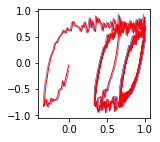

Iter 210: Total=0.0211 | Data=0.0201 | Phy=0.0021
Iter 220: Total=0.0206 | Data=0.0196 | Phy=0.0020
Iter 230: Total=0.0201 | Data=0.0191 | Phy=0.0020
Iter 240: Total=0.0197 | Data=0.0187 | Phy=0.0020
Iter 250: Total=0.0193 | Data=0.0183 | Phy=0.0020
Iter 260: Total=0.0189 | Data=0.0180 | Phy=0.0019
Iter 270: Total=0.0186 | Data=0.0176 | Phy=0.0018
Iter 280: Total=0.0182 | Data=0.0174 | Phy=0.0018
Iter 290: Total=0.0179 | Data=0.0171 | Phy=0.0017
Iter 300: Total=0.0176 | Data=0.0168 | Phy=0.0016
Iter 310: Total=0.0173 | Data=0.0165 | Phy=0.0015
Iter 320: Total=0.0170 | Data=0.0163 | Phy=0.0015
Iter 330: Total=0.0167 | Data=0.0160 | Phy=0.0014
Iter 340: Total=0.0164 | Data=0.0157 | Phy=0.0014
Iter 350: Total=0.0162 | Data=0.0155 | Phy=0.0014
Iter 360: Total=0.0159 | Data=0.0152 | Phy=0.0014
Iter 370: Total=0.0157 | Data=0.0150 | Phy=0.0014
Iter 380: Total=0.0154 | Data=0.0147 | Phy=0.0014
Iter 390: Total=0.0152 | Data=0.0144 | Phy=0.0015
Iter 400: Total=0.0149 | Data=0.0142 | Phy=0.0015


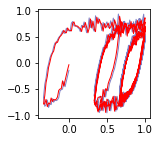

Iter 410: Total=0.0147 | Data=0.0139 | Phy=0.0015
Iter 420: Total=0.0144 | Data=0.0137 | Phy=0.0015
Iter 430: Total=0.0141 | Data=0.0134 | Phy=0.0015
Iter 440: Total=0.0139 | Data=0.0131 | Phy=0.0015
Iter 450: Total=0.0136 | Data=0.0128 | Phy=0.0015
Iter 460: Total=0.0133 | Data=0.0125 | Phy=0.0016
Iter 470: Total=0.0130 | Data=0.0122 | Phy=0.0016
Iter 480: Total=0.0126 | Data=0.0118 | Phy=0.0016
Iter 490: Total=0.0123 | Data=0.0115 | Phy=0.0016
Iter 500: Total=0.0120 | Data=0.0112 | Phy=0.0016
Iter 510: Total=0.0116 | Data=0.0108 | Phy=0.0017
Iter 520: Total=0.0113 | Data=0.0105 | Phy=0.0017
Iter 530: Total=0.0110 | Data=0.0101 | Phy=0.0017
Iter 540: Total=0.0107 | Data=0.0098 | Phy=0.0017
Iter 550: Total=0.0104 | Data=0.0095 | Phy=0.0017
Iter 560: Total=0.0101 | Data=0.0092 | Phy=0.0017
Iter 570: Total=0.0098 | Data=0.0089 | Phy=0.0017
Iter 580: Total=0.0095 | Data=0.0087 | Phy=0.0017
Iter 590: Total=0.0093 | Data=0.0085 | Phy=0.0016
Iter 600: Total=0.0091 | Data=0.0083 | Phy=0.0016


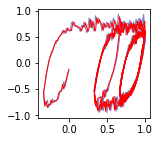

Iter 610: Total=0.0089 | Data=0.0082 | Phy=0.0016
Iter 620: Total=0.0088 | Data=0.0080 | Phy=0.0015
Iter 630: Total=0.0087 | Data=0.0079 | Phy=0.0015
Iter 640: Total=0.0085 | Data=0.0078 | Phy=0.0014
Iter 650: Total=0.0084 | Data=0.0078 | Phy=0.0014
Iter 660: Total=0.0084 | Data=0.0077 | Phy=0.0013
Iter 670: Total=0.0083 | Data=0.0076 | Phy=0.0013
Iter 680: Total=0.0082 | Data=0.0076 | Phy=0.0012
Iter 690: Total=0.0082 | Data=0.0076 | Phy=0.0012
Iter 700: Total=0.0081 | Data=0.0075 | Phy=0.0012
Iter 710: Total=0.0081 | Data=0.0075 | Phy=0.0011
Iter 720: Total=0.0080 | Data=0.0075 | Phy=0.0011
Iter 730: Total=0.0080 | Data=0.0074 | Phy=0.0011
Iter 740: Total=0.0079 | Data=0.0074 | Phy=0.0011
Iter 750: Total=0.0079 | Data=0.0074 | Phy=0.0010
Iter 760: Total=0.0079 | Data=0.0074 | Phy=0.0010
Iter 770: Total=0.0078 | Data=0.0073 | Phy=0.0010
Iter 780: Total=0.0078 | Data=0.0073 | Phy=0.0010
Iter 790: Total=0.0078 | Data=0.0073 | Phy=0.0010
Iter 800: Total=0.0078 | Data=0.0073 | Phy=0.0010


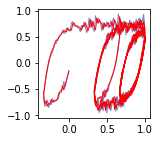

Iter 810: Total=0.0077 | Data=0.0073 | Phy=0.0010
Iter 820: Total=0.0077 | Data=0.0072 | Phy=0.0009
Iter 830: Total=0.0077 | Data=0.0072 | Phy=0.0009
Iter 840: Total=0.0076 | Data=0.0072 | Phy=0.0009
Iter 850: Total=0.0076 | Data=0.0072 | Phy=0.0009
Iter 860: Total=0.0076 | Data=0.0071 | Phy=0.0009
Iter 870: Total=0.0076 | Data=0.0071 | Phy=0.0009
Iter 880: Total=0.0075 | Data=0.0071 | Phy=0.0009
Iter 890: Total=0.0075 | Data=0.0071 | Phy=0.0009
Iter 900: Total=0.0075 | Data=0.0070 | Phy=0.0008
Iter 910: Total=0.0074 | Data=0.0070 | Phy=0.0008
Iter 920: Total=0.0074 | Data=0.0070 | Phy=0.0008
Iter 930: Total=0.0074 | Data=0.0070 | Phy=0.0008
Iter 940: Total=0.0073 | Data=0.0069 | Phy=0.0008
Iter 950: Total=0.0073 | Data=0.0069 | Phy=0.0008
Iter 960: Total=0.0073 | Data=0.0069 | Phy=0.0008
Iter 970: Total=0.0072 | Data=0.0069 | Phy=0.0008
Iter 980: Total=0.0072 | Data=0.0068 | Phy=0.0007
Iter 990: Total=0.0072 | Data=0.0068 | Phy=0.0007
Iter 1000: Total=0.0071 | Data=0.0068 | Phy=0.0007

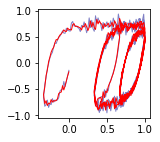

Iter 1010: Total=0.0071 | Data=0.0067 | Phy=0.0007
Iter 1020: Total=0.0071 | Data=0.0067 | Phy=0.0007
Iter 1030: Total=0.0070 | Data=0.0067 | Phy=0.0007
Iter 1040: Total=0.0070 | Data=0.0066 | Phy=0.0007
Iter 1050: Total=0.0069 | Data=0.0066 | Phy=0.0007
Iter 1060: Total=0.0069 | Data=0.0066 | Phy=0.0007
Iter 1070: Total=0.0069 | Data=0.0065 | Phy=0.0007
Iter 1080: Total=0.0068 | Data=0.0065 | Phy=0.0006
Iter 1090: Total=0.0068 | Data=0.0065 | Phy=0.0006
Iter 1100: Total=0.0068 | Data=0.0064 | Phy=0.0006
Iter 1110: Total=0.0067 | Data=0.0064 | Phy=0.0006
Iter 1120: Total=0.0067 | Data=0.0064 | Phy=0.0006
Iter 1130: Total=0.0066 | Data=0.0063 | Phy=0.0006
Iter 1140: Total=0.0066 | Data=0.0063 | Phy=0.0006
Iter 1150: Total=0.0066 | Data=0.0063 | Phy=0.0006
Iter 1160: Total=0.0065 | Data=0.0062 | Phy=0.0006
Iter 1170: Total=0.0065 | Data=0.0062 | Phy=0.0006
Iter 1180: Total=0.0065 | Data=0.0062 | Phy=0.0006
Iter 1190: Total=0.0064 | Data=0.0062 | Phy=0.0006
Iter 1200: Total=0.0064 | Data=

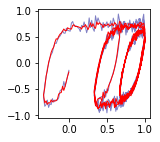

Iter 1210: Total=0.0064 | Data=0.0061 | Phy=0.0005
Iter 1220: Total=0.0063 | Data=0.0061 | Phy=0.0005
Iter 1230: Total=0.0063 | Data=0.0060 | Phy=0.0005
Iter 1240: Total=0.0063 | Data=0.0060 | Phy=0.0005
Iter 1250: Total=0.0063 | Data=0.0060 | Phy=0.0005
Iter 1260: Total=0.0062 | Data=0.0060 | Phy=0.0005
Iter 1270: Total=0.0062 | Data=0.0060 | Phy=0.0005
Iter 1280: Total=0.0062 | Data=0.0059 | Phy=0.0005
Iter 1290: Total=0.0062 | Data=0.0059 | Phy=0.0005
Iter 1300: Total=0.0061 | Data=0.0059 | Phy=0.0005
Iter 1310: Total=0.0061 | Data=0.0059 | Phy=0.0005
Iter 1320: Total=0.0061 | Data=0.0059 | Phy=0.0005
Iter 1330: Total=0.0061 | Data=0.0058 | Phy=0.0005
Iter 1340: Total=0.0061 | Data=0.0058 | Phy=0.0005
Iter 1350: Total=0.0060 | Data=0.0058 | Phy=0.0005
Iter 1360: Total=0.0060 | Data=0.0058 | Phy=0.0005
Iter 1370: Total=0.0060 | Data=0.0058 | Phy=0.0005
Iter 1380: Total=0.0060 | Data=0.0058 | Phy=0.0005
Iter 1390: Total=0.0060 | Data=0.0057 | Phy=0.0005
Iter 1400: Total=0.0060 | Data=

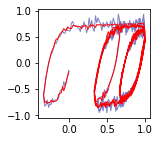

Iter 1410: Total=0.0059 | Data=0.0057 | Phy=0.0004
Iter 1420: Total=0.0059 | Data=0.0057 | Phy=0.0004
Iter 1430: Total=0.0059 | Data=0.0057 | Phy=0.0004
Iter 1440: Total=0.0059 | Data=0.0057 | Phy=0.0004
Iter 1450: Total=0.0059 | Data=0.0057 | Phy=0.0004
Iter 1460: Total=0.0059 | Data=0.0057 | Phy=0.0004
Iter 1470: Total=0.0059 | Data=0.0057 | Phy=0.0004
Iter 1480: Total=0.0059 | Data=0.0057 | Phy=0.0004
Iter 1490: Total=0.0059 | Data=0.0056 | Phy=0.0004
Iter 1500: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1510: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1520: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1530: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1540: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1550: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1560: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1570: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1580: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1590: Total=0.0058 | Data=0.0056 | Phy=0.0004
Iter 1600: Total=0.0057 | Data=

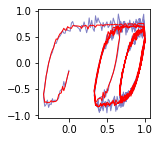

Iter 1610: Total=0.0057 | Data=0.0056 | Phy=0.0004
Iter 1620: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1630: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1640: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1650: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1660: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1670: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1680: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1690: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1700: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1710: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1720: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1730: Total=0.0057 | Data=0.0055 | Phy=0.0004
Iter 1740: Total=0.0057 | Data=0.0055 | Phy=0.0003
Iter 1750: Total=0.0056 | Data=0.0055 | Phy=0.0003
Iter 1760: Total=0.0056 | Data=0.0055 | Phy=0.0003
Iter 1770: Total=0.0056 | Data=0.0055 | Phy=0.0003
Iter 1780: Total=0.0056 | Data=0.0055 | Phy=0.0003
Iter 1790: Total=0.0056 | Data=0.0055 | Phy=0.0003
Iter 1800: Total=0.0056 | Data=

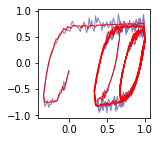

Iter 1810: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1820: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1830: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1840: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1850: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1860: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1870: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1880: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1890: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1900: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1910: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1920: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1930: Total=0.0056 | Data=0.0054 | Phy=0.0003
Iter 1940: Total=0.0055 | Data=0.0054 | Phy=0.0003
Iter 1950: Total=0.0055 | Data=0.0054 | Phy=0.0003
Iter 1960: Total=0.0055 | Data=0.0054 | Phy=0.0003
Iter 1970: Total=0.0055 | Data=0.0054 | Phy=0.0003
Iter 1980: Total=0.0055 | Data=0.0054 | Phy=0.0003
Iter 1990: Total=0.0055 | Data=0.0054 | Phy=0.0003
Iter 2000: Total=0.0055 | Data=

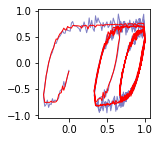

In [10]:
niters=2000
optimizer = optim.NAdam(
    TANNnet.parameters(), 
    lr=1e-4)
loss_components_hist = [[] for _ in range(3)]
total_loss_hist = []  
data_loss_hist = []   
phy_loss_hist = []    
phy_weight = 0.5
loss_fn = torch.nn.MSELoss()

for itr in range(1, niters + 1):
    if itr % test_freq == 0:
        fig, ax = plt.subplots(figsize=(2, 2))
    
    epoch_data = 0.0
    epoch_phy = 0.0
    epoch_losses = [0.0]*3

    for i in range(ntrain):
        pred = TANNnet(input_tv[i,:,0])
        inputs = input_tv[i,:,0]
        targets = output_tv[i,:,0]

        losses = [
            loss_fn(pred[:,0], output_tv[i,:,0,0]),
            loss_fn(pred[:,1], output_tv[i,:,0,1]),
            loss_fn(pred[:,2], output_tv[i,:,0,2])]
        
        data_loss = sum(losses)

        pred_denergy = TANNnet.DeNormalize(pred[:,3], prm_df)
        pred_energy = pred_denergy.cumsum(dim=0)
        pred_dissipation = TANNnet.DeNormalize(pred[:,4], prm_d)
        
        dstrain_real = TANNnet.DeNormalize(inputs[:,1], prm_da)
        stress_tdt_tv_real = TANNnet.DeNormalize(targets[:,2], prm_s)

        energy_balance = (pred_denergy + pred_dissipation - stress_tdt_tv_real * dstrain_real)
        non_neg_term = torch.relu(-pred_energy) + torch.relu(-pred_dissipation)
        phy_loss = torch.mean(energy_balance.pow(2)) + torch.mean(non_neg_term)
        total_loss = data_loss + phy_weight * phy_loss

        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        for idx in range(3):
            epoch_losses[idx] += losses[idx].item()

        epoch_data += data_loss.item()
        epoch_phy += phy_loss.item()

    avg_losses = [loss/ntrain for loss in epoch_losses]
    for idx in range(3):
        loss_components_hist[idx].append(avg_losses[idx])

    avg_total = (epoch_data + phy_weight*epoch_phy) / ntrain
    avg_data = epoch_data / ntrain
    avg_phy = epoch_phy / ntrain
    
    total_loss_hist.append(avg_total)
    data_loss_hist.append(avg_data)
    phy_loss_hist.append(avg_phy)

    if itr % 10 == 0:
        print(f"Iter {itr}: Total={avg_total:.4f} | Data={avg_data:.4f} | Phy={avg_phy:.4f}")

    if itr % test_freq == 0:
        ax.plot(strain_t_tv[i,:,0], output_tv[i,:,0,2].cpu().numpy(),
               color='darkblue', alpha=0.5, linestyle='-', linewidth=1)
        ax.plot(strain_t_tv[i,:,0], pred.detach()[:,2].cpu().numpy(),
               color='red', linewidth=1)
        plt.show()

#### Plot loss history

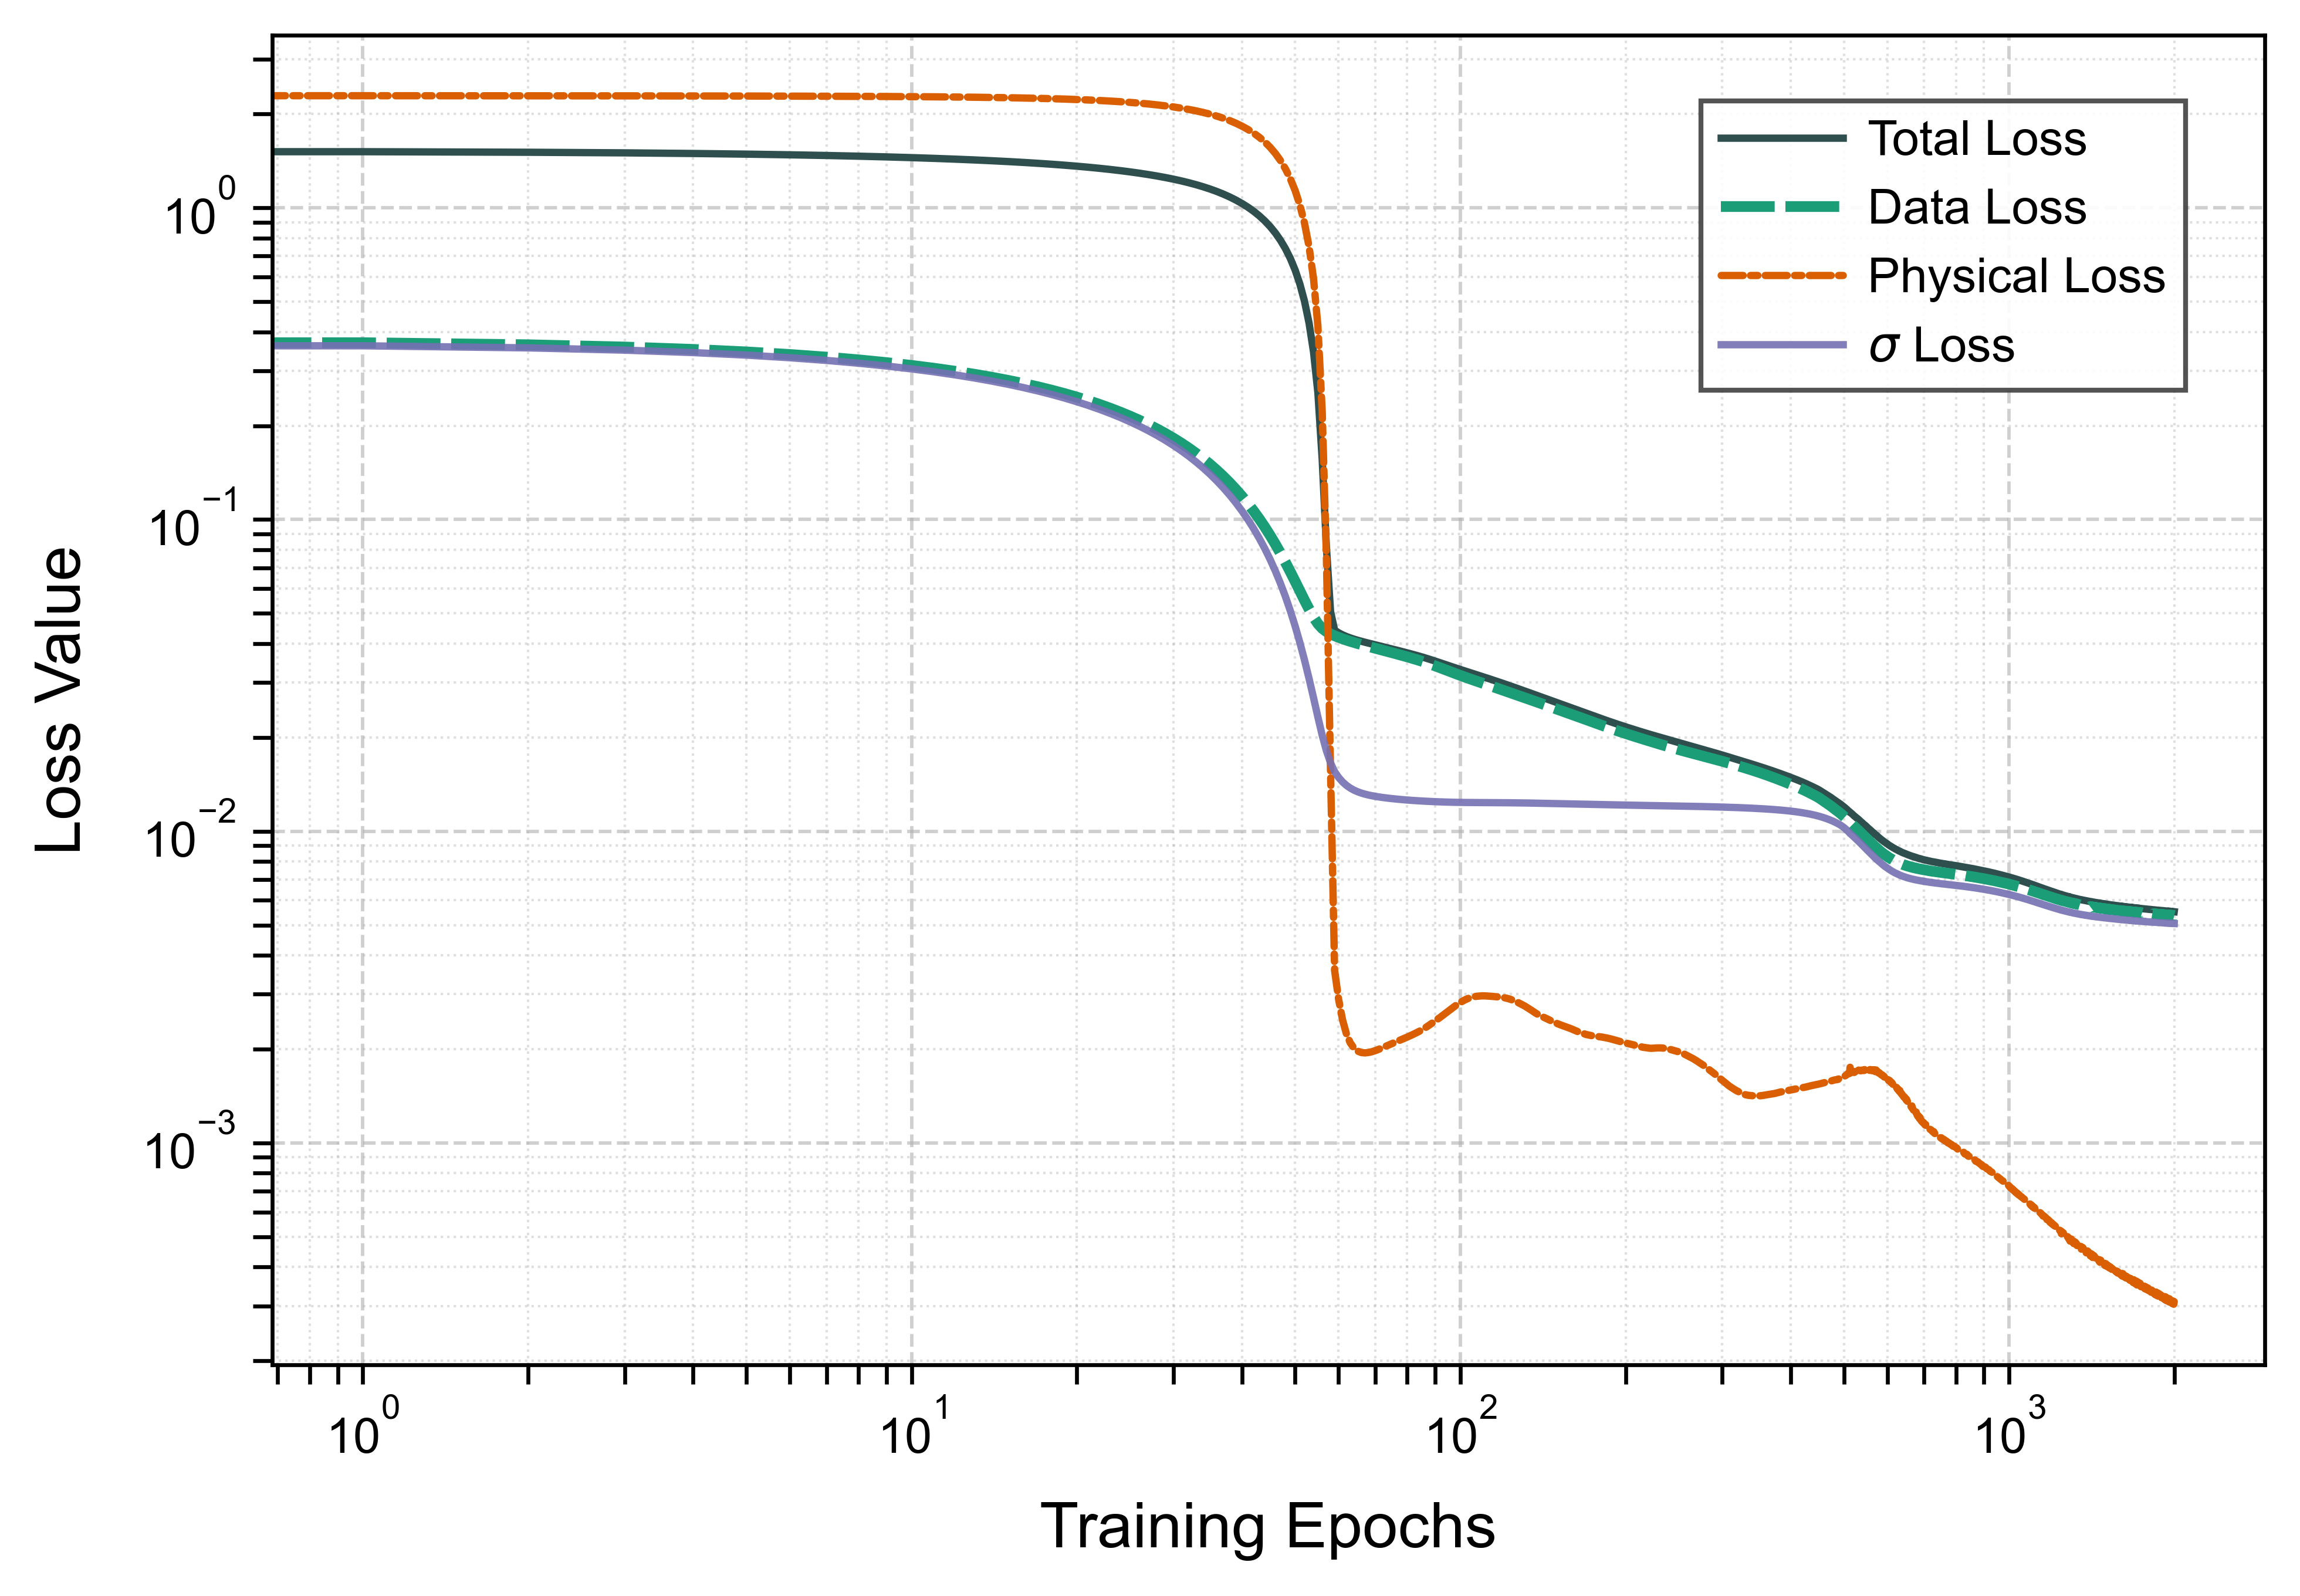

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.6,
    'font.family': 'Arial'
})

fig, ax = plt.subplots(figsize=(7, 5), dpi=600)

COLORS = {
    'total': '#2F4F4F',
    'data': '#1b9e77',
    'physics': '#d95f02',
    'stress': '#7570b3'}

all_lines = [
    ax.loglog(total_loss_hist, color=COLORS['total'], linestyle='-', label='Total Loss')[0],
    ax.loglog(data_loss_hist, color=COLORS['data'], linestyle=(0, (5, 1)), 
             linewidth=2.2, label='Data Loss')[0],
    ax.loglog(phy_loss_hist, color=COLORS['physics'], linestyle=(0, (3, 1, 1, 1)), 
             dash_capstyle='round', label='Physical Loss')[0],
    ax.loglog(loss_components_hist[2], color=COLORS['stress'], linestyle='-',
             alpha=0.9, label='$\\sigma$ Loss')[0]
]

ax.set_xlabel('Training Epochs', labelpad=8)
ax.set_ylabel('Loss Value',labelpad=10)
ax.tick_params(axis='both', which='both', width=0.8, length=4)

ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.6)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

legend = ax.legend(
    handles=all_lines,
    loc='upper right',
    bbox_to_anchor=(0.98, 0.98),
    frameon=True,
    fancybox=False,
    framealpha=0.9,
    edgecolor='#404040',
    handlelength=2.5,
    handletextpad=0.5,
    borderaxespad=0.8
)

plt.tight_layout(pad=2.0)

# plt.savefig('figures/1D-noisy5p-loss.pdf', bbox_inches='tight', dpi=1000)
plt.show()

### Model at inference (test set)

In [12]:
for i in range(ntest):
    if i == 0:
        pred_test = TANNnet.forward(input_test[i,:,0])
        pred_test = pred_test[None,:,:]
    else:
        pred_test_i = TANNnet.forward(input_test[i,:,0])
        pred_test = torch.cat((pred_test,pred_test_i[None,:,:]),0)
        
pred_test = pred_test.cpu().detach()

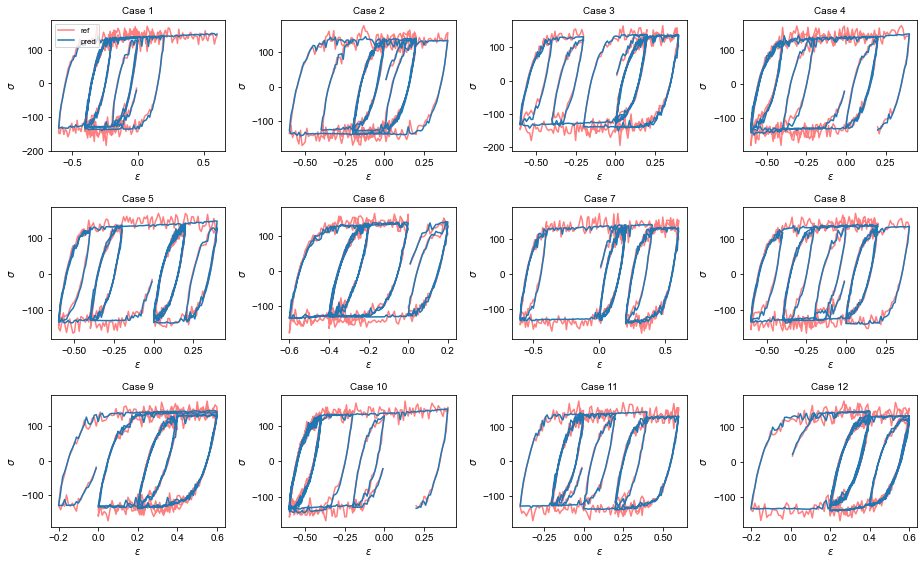

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(13, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, ax in enumerate(axes.flat):
    ax.plot(
        TANNnet.DeNormalize(strain_tdt_test[i,:,:,0],prm_a)*100, 
        TANNnet.DeNormalize(stress_tdt_test[i,:,0,0],prm_s), 
        color='red', 
        alpha=0.5, 
        linewidth=1.5, 
        label='ref'
    )
    ax.plot(
        TANNnet.DeNormalize(strain_tdt_test[i,:,:,0],prm_a)*100, 
        TANNnet.DeNormalize(pred_test[i,:,2],prm_s), 
        alpha=1, 
        linewidth=1.5, 
        label='pred', 
        markeredgewidth=0.3, 
        linestyle='-'
    )
    ax.set_ylabel('$\sigma$', fontsize=10)
    ax.set_xlabel('$\\varepsilon$', fontsize=10)
    ax.set_title(f'Case {i+1}', fontsize=10)
    if i == 0:
        ax.legend(fontsize=8, loc='upper left')
plt.tight_layout()
plt.show()